In [83]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pymulticonsensus
from time import time
import sys
sys.path.append('../dataset_comparison/')
from utils import get_soft_assignment, draw_soft_assignment, draw_labeling, model_type

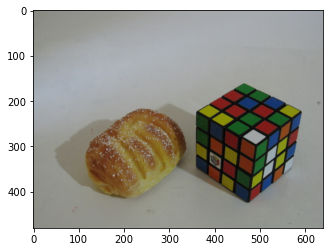

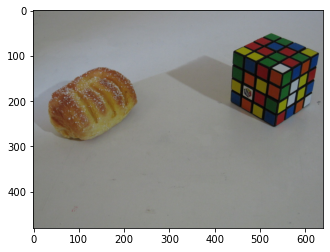

In [84]:
# Load the images
img1 = cv2.cvtColor(cv2.imread('../build/data/breadcube/breadcube1.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../build/data/breadcube/breadcube2.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [85]:
#We will detect ORB features and match them with cross-check test
det = cv2.SIFT_create(8000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher()

SNN_threshold = 0.8
matches = bf.knnMatch(descs1, descs2, k=2)

# Apply ratio test
snn_ratios = []
tentatives = []
for m, n in matches:
    if m.distance < SNN_threshold * n.distance:
        tentatives.append(m)
        snn_ratios.append(m.distance / n.distance)

sorted_indices = np.argsort(snn_ratios)
tentatives = list(np.array(tentatives)[sorted_indices])

In [86]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)

def draw_matches(kps1, kps2, tentatives, img1, img2, mask):    
    matchesMask = mask.ravel().tolist()
    
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,decolorize(img2),kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.show() 
    return

In [87]:
def get_motions(img1, img2, correspondences, inlier_threshold = 2.05):    
    motions = pymulticonsensus.findTwoViewMotions(
        np.ascontiguousarray(correspondences), 
        img1.shape[1], img1.shape[0], 
        img2.shape[1], img2.shape[0],
        threshold = inlier_threshold,
        confidence = 0.999,
        neighborhood_ball_radius = 20.0,
        maximum_tanimoto_similarity = 0.85,
        starting_hypothesis_number = 10,
        added_hypothesis_number = 10,
        max_iters = 75,
        minimum_point_number = 20,
        sampler_id = 1)  
    return np.array(motions)

In [88]:
t = time()

inlier_threshold = 1.0
correspondences = np.float32([ (kps1[m.queryIdx].pt + kps2[m.trainIdx].pt) for m in tentatives ]).reshape(-1,4)   
motions = get_motions(img1, img2, correspondences, inlier_threshold)
model_number = int(motions.shape[0] / 3)

print ('Time = ', time()-t, ' sec')
print ('Models found = {}'.format(model_number))

Time =  0.04312777519226074  sec
Models found = 2


Drawing a soft labeling


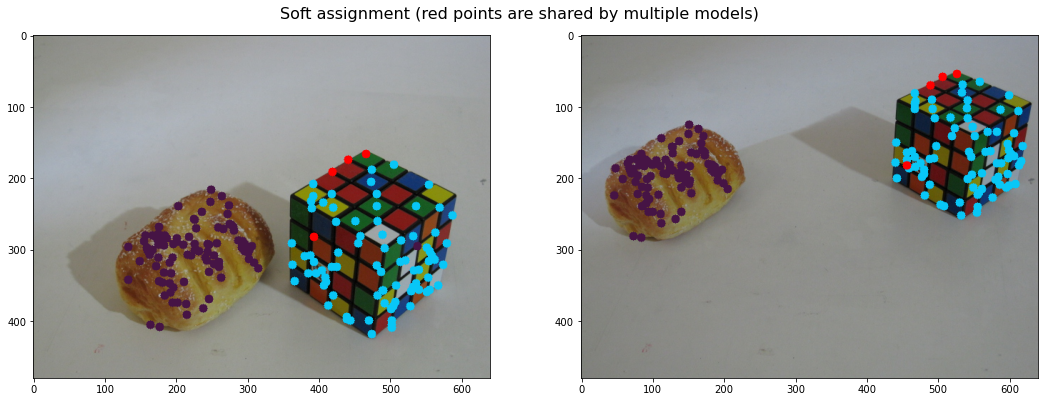

In [89]:
print("Drawing a soft labeling")
soft_assignment = pymulticonsensus.getSoftLabeling(
	motions.reshape(model_number, 9),
	correspondences,
	model_type("two_view_motion"),
	inlier_threshold)
draw_soft_assignment(img1, img2, soft_assignment, correspondences, radius=6, figsize=(18,12))


Drawing a hard labeling determined by PEARL


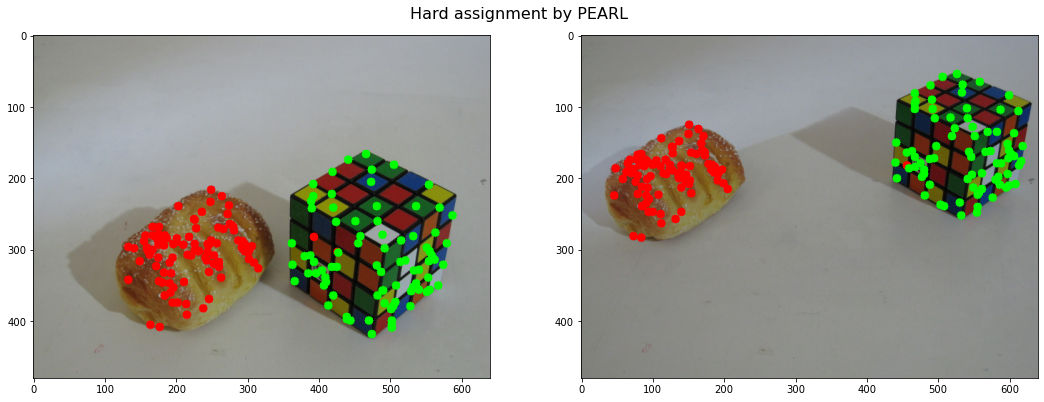

In [90]:
print("Drawing a hard labeling determined by PEARL")
# Get hard labeling by a energy-based labeling of PEARL
if model_number > 0:
    labeling = pymulticonsensus.getLabeling(
        motions.reshape(model_number, 9),
        correspondences,
        model_type("two_view_motion"),
        inlier_threshold,
        20.0,
        0,
        0)
    
    # The estimator returns -1 as the outlier class.
    # In the drawing function, the outlier label is <model #> + 1
    mask = labeling == -1
    labeling[mask] = model_number
else:
    labeling = np.zeros((correspondences.shape[0], 1))
    
draw_labeling(img1, img2, labeling, correspondences, radius=6, figsize=(18,12))